<a href="https://colab.research.google.com/github/MehrdadJalali-AI/RecommenderSystems/blob/main/ContextAware_MovieRecommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Context-Aware and Explainable Recommender System

**Notebook:** ContextAware_MovieRecommender_Technical.ipynb  
  

---

## 1. Introduction and Theoretical Background

Context-Aware Recommender Systems (CARS) extend the traditional formulation of user-item interactions by introducing a contextual variable \( c \), representing situational factors (e.g., time, location, mood).  
Formally, the predicted preference is modeled as:

\[
\hat{r}_{u,i,c} = f(u, i, c)
\]

This enables the model to adapt its recommendations depending on external conditions.  
In this notebook, we demonstrate a **contextual re-ranking approach** combined with an **explainability layer**, which decomposes recommendation scores into interpretable feature contributions.

---



## 2. Setup and Imports

We import the necessary libraries for feature extraction, similarity computation, and visualization.


In [1]:

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt



## 3. Dataset and Feature Representation

We use a minimal **MovieLens-like dataset** consisting of seven movies, annotated with genres, average ratings, and movie lengths.  
Each movie is represented as a hybrid feature vector:

\[
X_i = [g_i, r_i, l_i]
\]

where \( g_i \) is the genre embedding, \( r_i \) is the scalar rating, and \( l_i \) is the normalized movie length.


In [2]:

movies = pd.DataFrame({
    'title': ['Toy Story', 'Finding Nemo', 'Shrek', 'The Lion King', 'Inception', 'Titanic', 'The Dark Knight'],
    'genre': ['Animation|Adventure', 'Animation|Family', 'Animation|Comedy', 'Animation|Adventure',
              'Sci-Fi|Thriller', 'Romance|Drama', 'Action|Thriller'],
    'rating': [8.3, 8.1, 7.9, 8.5, 8.8, 7.8, 9.0],
    'length': [81, 100, 95, 88, 148, 195, 152]
})
movies


,title,genre,rating,length
0,Toy Story,Animation|Adventure,8.3,81
1,Finding Nemo,Animation|Family,8.1,100
2,Shrek,Animation|Comedy,7.9,95
3,The Lion King,Animation|Adventure,8.5,88
4,Inception,Sci-Fi|Thriller,8.8,148
5,Titanic,Romance|Drama,7.8,195
6,The Dark Knight,Action|Thriller,9.0,152



## 4. Feature Engineering and Base Similarity

We convert genres into a binary feature matrix using **CountVectorizer**, then concatenate it with normalized rating and length features.  
This hybrid representation enables multi-dimensional similarity computation:

\[
S = \text{cosine\_similarity}(X, X)
\]


In [3]:

vec = CountVectorizer()
genre_features = vec.fit_transform(movies['genre']).toarray()

X = np.hstack([
    genre_features,
    movies[['rating']].values,
    (movies[['length']]/movies['length'].max()).values
])

similarity = cosine_similarity(X)



## 5. Contextual Re-Ranking Function

We define a context-aware re-weighting mechanism that modifies similarity scores based on the **time-of-day** context.  

The adjusted similarity is computed as:
\[
s'_{ij} = s_{ij} \times w_c(j)
\]

Where \( w_c(j) \) is a contextual weight:
- **Morning**: boosts animated and short movies.  
- **Night**: boosts dramatic or thriller movies.


In [4]:

def apply_context_weights(sim_scores, movie_idx, context):
    if context == 'morning':
        if 'Animation' in movies.loc[movie_idx, 'genre']:
            sim_scores *= 1.1
        sim_scores *= np.where(movies['length'] < 120, 1.05, 0.95)
    elif context == 'night':
        if any(g in movies.loc[movie_idx, 'genre'] for g in ['Drama','Thriller']):
            sim_scores *= 1.1
        sim_scores *= np.where(movies['genre'].str.contains('Drama|Thriller'), 1.05, 0.9)
    return sim_scores



## 6. Explainability Layer

To enhance transparency, we perform a **post-hoc feature contribution analysis**.  
Each recommended item’s score is decomposed into its contributing factors:  
- **Genre Similarity** (\(s_g\))  
- **Length Similarity** (\(s_l\))  
- **Rating Similarity** (\(s_r\))  
- **Contextual Boost** (\(s_c\))  

These are visualized using a normalized stacked bar chart to highlight feature importance.


In [5]:

def recommend_with_context(title, context='morning', top_n=3):
    idx = movies[movies['title'].str.contains(title, case=False)].index[0]
    base_scores = similarity[idx].copy()
    ctx_scores = apply_context_weights(base_scores.copy(), idx, context)

    ctx_scores = ctx_scores / ctx_scores.max()
    top_idx = ctx_scores.argsort()[::-1][1:top_n+1]

    print(f"🎬 Recommendations for '{title}' (context = {context}):\n")
    for i in top_idx:
        genre_sim = cosine_similarity(genre_features[idx].reshape(1, -1), genre_features[i].reshape(1, -1))[0,0]
        length_sim = 1 - abs(movies.loc[idx,'length'] - movies.loc[i,'length']) / movies['length'].max()
        rating_sim = 1 - abs(movies.loc[idx,'rating'] - movies.loc[i,'rating']) / 10
        ctx_boost = max(ctx_scores[i] - base_scores[i], 0)

        contribs = np.array([genre_sim, length_sim, rating_sim, ctx_boost])
        contribs = contribs / contribs.sum()

        print(f"{movies.loc[i,'title']:20} | Total Score={ctx_scores[i]:.3f} | "
              f"Genre={genre_sim:.2f}, Length={length_sim:.2f}, Rating={rating_sim:.2f}, ContextBoost={ctx_boost:+.2f}")

        plt.bar(['Genre','Length','Rating','ContextBoost'], contribs, color=['#1f77b4','#ff7f0e','#2ca02c','#d62728'])
        plt.title(f"Feature Contributions for '{movies.loc[i,'title']}'")
        plt.ylabel('Normalized Importance')
        plt.ylim(0,1)
        plt.show()



## 7. Demonstration: Contextual Adaptation

We demonstrate the system by querying the same movie ("Toy Story") under two different contextual conditions.


🎬 Recommendations for 'Toy Story' (context = morning):

The Lion King        | Total Score=1.000 | Genre=1.00, Length=0.96, Rating=0.98, ContextBoost=+0.00


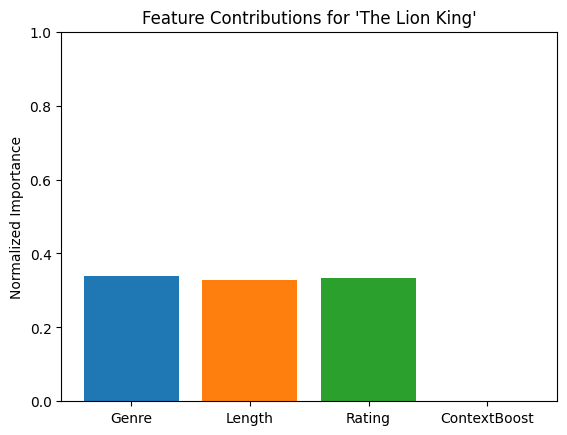

Finding Nemo         | Total Score=0.986 | Genre=0.50, Length=0.90, Rating=0.98, ContextBoost=+0.00


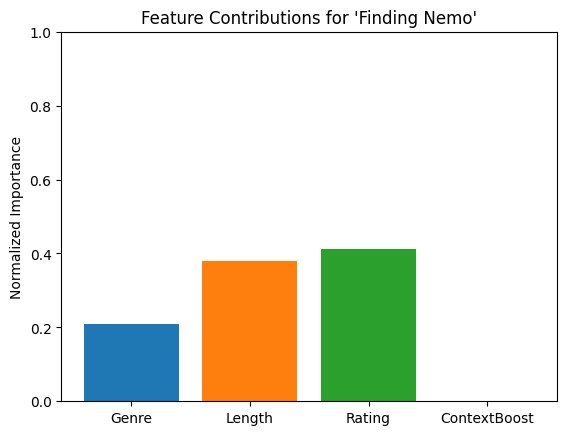

Shrek                | Total Score=0.985 | Genre=0.50, Length=0.93, Rating=0.96, ContextBoost=+0.00


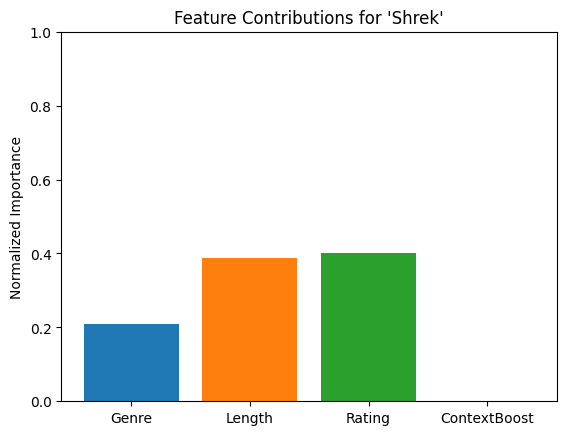

🎬 Recommendations for 'Toy Story' (context = night):

Titanic              | Total Score=0.994 | Genre=0.00, Length=0.42, Rating=0.95, ContextBoost=+0.03


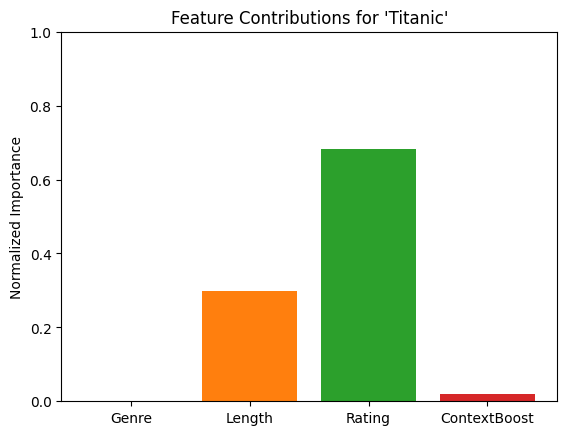

Inception            | Total Score=0.993 | Genre=0.00, Length=0.66, Rating=0.95, ContextBoost=+0.03


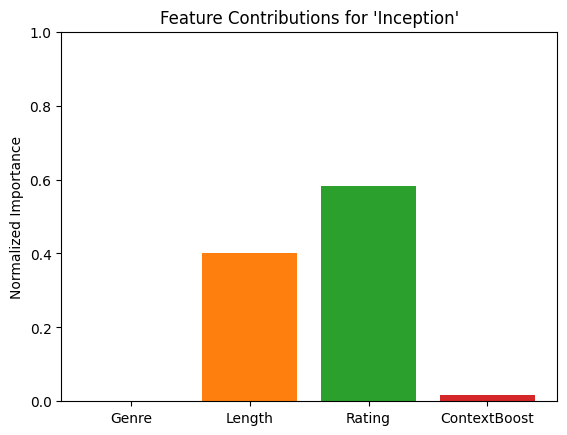

Toy Story            | Total Score=0.881 | Genre=1.00, Length=1.00, Rating=1.00, ContextBoost=+0.00


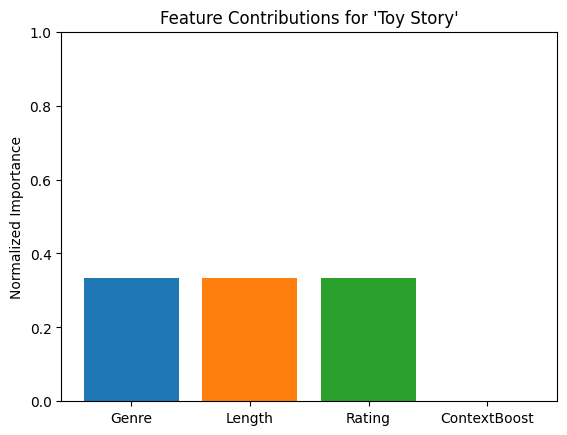

In [6]:

recommend_with_context("Toy Story", context="morning")
recommend_with_context("Toy Story", context="night")
